In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha

In [3]:
# pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

# data_dir = "/Users/smsharma/QuasarSims/"

In [4]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1527 subhalos between 7.0 and 10.0


/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become 

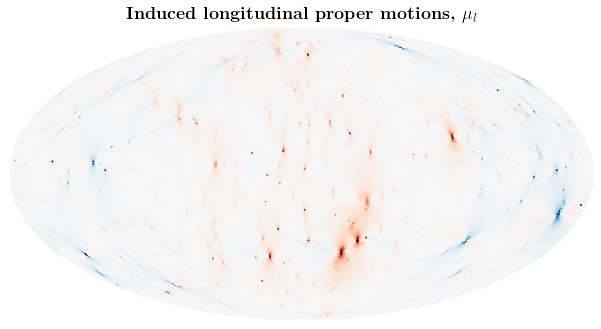

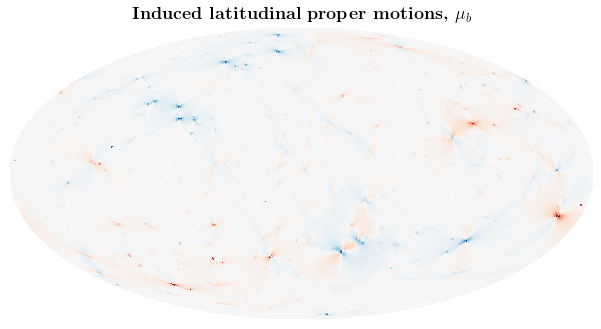

In [5]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [6]:
import sys
sys.path.append("../")

from models.embedding import SphericalGraphCNN

In [7]:
nside_list = [64, 32, 16, 8, 4, 2, 1]

In [8]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, mask_ring = False)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])


In [9]:
import torch
in_map = torch.Tensor((sim.mu_qsrs.reshape((1, -1, 2))))
in_map.shape

torch.Size([1, 49152, 2])

In [10]:
log_mean = torch.log(torch.mean(in_map, axis=1))
log_std = torch.log(torch.var(in_map, axis=1).sqrt())

log_mean = log_mean.reshape((1, -1, 2))
log_std = log_std.reshape((1, -1, 2))

data_map = torch.cat([in_map], axis=1)
data_map.shape

torch.Size([1, 49152, 2])

In [11]:
data_map = data_map.view(-1, 2, 49152)

In [12]:
sg = SphericalGraphCNN(nside_list, indexes_list, in_ch=2)

In [14]:
data_map = torch.cat(4 * [data_map])

In [15]:
data_map.shape

torch.Size([4, 2, 49152])

In [16]:
theta = torch.ones([4, 1000])

In [17]:
sg(data_map, theta).shape

torch.Size([4, 64])


## Analysis

In [14]:
import sys
sys.path.append("../")
from sbi.neural_nets.flow import build_maf

In [15]:
from sbi.neural_nets.classifier import build_mlp_mixed_classifier
from sbi import utils
import torch

In [230]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [231]:
from tqdm.notebook import tqdm

In [238]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

Simulating 1172 subhalos between 7.0 and 10.0


In [239]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [240]:
n_trials = 10
n_test = 30

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test).T
    
#     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

    theta_test = torch.linspace(0., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test[i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulating 1226 subhalos between 7.0 and 10.0


Simulating 1204 subhalos between 7.0 and 10.0
Simulating 1205 subhalos between 7.0 and 10.0
Simulating 1252 subhalos between 7.0 and 10.0
Simulating 1198 subhalos between 7.0 and 10.0
Simulating 1213 subhalos between 7.0 and 10.0
Simulating 1183 subhalos between 7.0 and 10.0
Simulating 1192 subhalos between 7.0 and 10.0
Simulating 1168 subhalos between 7.0 and 10.0
Simulating 1173 subhalos between 7.0 and 10.0


In [241]:
out_mean = np.mean(out, axis=0)
out_68 = np.percentile(out, [18, 84], axis=0)
out_95 = np.percentile(out, [2.5, 97.5], axis=0)

In [242]:
from scipy.stats import chi2
from scipy.stats import norm

In [243]:
# llrmin, llrmax = 0., 15.

# for out_inst in out:
#     llr = out_inst

#     from scipy.interpolate import interp1d
#     from scipy.misc import derivative

#     x0 = theta_test.squeeze().detach().numpy()[np.argmax(llr)]
#     dx = 10.
    
#     std = np.sqrt(- 1 / derivative(interp1d(theta_test.squeeze().detach().numpy(), llr), x0=x0, dx=dx, n=2))
#     print(std)

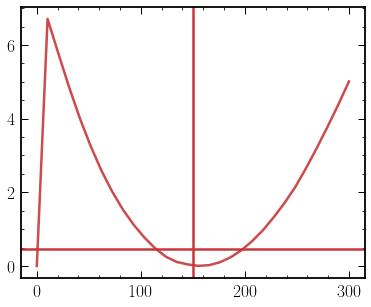

In [244]:
llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr)

# llr = -2 * out_68
# llr = (llr.T - np.min(llr, axis=1)).T
# llr = np.clip(llr, llrmin, llrmax)

# plt.fill_between(theta_test.squeeze().detach().numpy(), llr[0], llr[1], alpha=0.1)

# llr = -2 * out_95
# llr = (llr.T - np.min(llr, axis=1)).T
# llr = np.clip(llr, llrmin, llrmax)

# plt.fill_between(theta_test.squeeze().detach().numpy(), llr[0], llr[1], alpha=0.1)

# for out_inst in out:
#     llr = - 2 * out_inst
#     llr -= np.min(llr)
#     llr = np.clip(llr, llrmin, llrmax)
#     plt.plot(theta_test.squeeze().detach().numpy(), llr)
    
plt.axhline(chi2.isf(.5, 1))
plt.axvline(150)

In [223]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

In [123]:
# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [98]:
# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1.1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

C_l_mu = pspecpop.get_C_l_total_ary();

  0%|          | 0/50 [00:00<?, ?it/s]

In [245]:
# Test

sigma_mu = .10
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.01

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

In [246]:
M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

Text(0.5, 1.01, '\\bf{Non-Gaussian astrometric signature}')

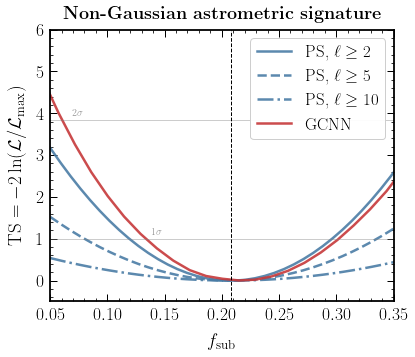

In [248]:
signal = np.linspace(1e-3, 2, 100)

ls_list = ['-', '--', '-.']

for i_l, l_min in enumerate([2, 5, 10]):

    parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=300, l_min_alpha=2, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)

    sigma=fshr.pars_vary[0].sigma

    x_arr=np.linspace(0, 2)
    LL_ary = norm.logpdf(x_arr, fDM_base, sigma)
    plt.plot(f_sub_fid * x_arr, -2 * (LL_ary - np.max(LL_ary)), label=r"PS, $\ell \geq {}$".format(l_min), ls=ls_list[i_l], color=cols_default[1])


llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

offset = 0  # (f_sub_fid - (f_sub_fid / 150) * theta_test.squeeze().detach().numpy()[np.argmin(llr[3])])
plt.plot(offset + (f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, label="GCNN", color=cols_default[0])


plt.axhline(chi2.isf(1 - .95, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / 3, chi2.isf(1 - .95, 1) + 0.1, r"$2\sigma$",  color='grey', alpha=0.8)

plt.axhline(chi2.isf(1 - .68, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / (3 / 2), chi2.isf(1 - .68, 1) + 0.1, r"$1\sigma$",  color='grey', alpha=0.8)

plt.axvline(f_sub_fid, color='k', lw=1, ls='--')

plt.ylim(-0.5, 6)
plt.xlim(0.05, 0.35)

plt.legend(loc='upper right', frameon=True, framealpha=0.95)

plt.xlabel(r"$f_\mathrm{sub}$")
plt.ylabel(r"$\mathrm{TS}  = -2 \ln  (\mathcal L / \mathcal L_\mathrm{max}) $")

plt.title(r"\bf{Non-Gaussian astrometric signature}", y=1.01)

In [190]:
import healpy as hp
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea
sigma_pix = .10 / np.sqrt(N_q_pix)
sigma_pix

# the_map = np.load("../../sbi-astrometry/data/x_train_49.npy")[4, 0] 
# the_map += np.random.normal(loc=0, scale=sigma_pix, size=the_map.shape)
# hp.mollview(the_map, nest=True, cmap='RdBu_r')

0.002217025033688163

In [90]:
np.linspace(0.0002, 0.005, 10)

array([0.0002    , 0.00073333, 0.00126667, 0.0018    , 0.00233333,
       0.00286667, 0.0034    , 0.00393333, 0.00446667, 0.005     ])

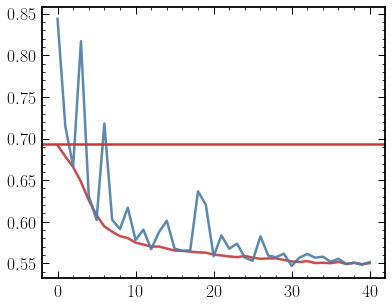

In [91]:
val_loss = np.loadtxt('../data/logs/mlruns/2/d8c14c645f624a24abaad5465a94ea53/metrics/train_loss_epoch', )
plt.plot(val_loss[:, 1][::2])
val_loss = np.loadtxt('../data/logs/mlruns/2/d8c14c645f624a24abaad5465a94ea53/metrics/val_loss', )
plt.plot(val_loss[:, 1][::2])
plt.axhline(.693)
# plt.xlim(0, 100)

In [145]:
import torch.nn as nn

In [146]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 

In [171]:
gn = GaussianNoise(sigma=0.0022)
x = torch.ones((1000000)) * 1000
gn(x).std()

tensor(0.0022)

In [172]:
np.random.normal(loc=0, scale=0.0022 / 1., size=(1000)).std()

0.002194240098910951